In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')

df

Now we want to predict X values (can change for Y, Z):

In [ ]:
#Create a new dataframe with only the x column
data = df.filter(['x']) # CHANGE FOR Y,Z

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

training_data_len

In [ ]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Set roll-back window
window = 60 # default was set to 60 before

In [ ]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

In [ ]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - window: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

# Model 1: Uni-Variate

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1))) # input_shape = (60,1)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

### Plot:

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(train['x'])
plt.plot(valid[['x', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Error plot:

In [ ]:
valid['Error']=abs(valid.Predictions-valid.x)/6738 # the normalization ct is taken as ISS semi-major axis
valid.Error.plot()
# add labels and units!!!

# Model 2: Multi-Variate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [2]:
predicted_feature = 0 # input number from 0 to 5, coresponds to x,y,z,vv_x,vv_y,vv_z

In [3]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, predicted_feature]) # 2 stands for prediction of Z!!! (3rd col)
    return np.array(dataX), np.array(dataY)

In [4]:
# load the dataset
dataset = df.values

In [5]:
dataset[1,0]

39159.545913907335

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size

train=dataset[0 : train_size]
test=dataset[train_size - 60 : ]

In [7]:
train.shape

(800, 6)

In [8]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# reshape into X=t and Y=t+1
look_back = 60 # this is the window
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [length of train/test data, window size (def=60), features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
testX = np.reshape(testX, (testX.shape[0],look_back, 6))

In [9]:
trainX.shape

(740, 60, 6)

In [10]:
testX.shape

(200, 60, 6)

In [11]:
testY.shape

(200,)

Epoch 1/100
3/3 [==============================] - 0s 143ms/step - loss: 0.3548
Epoch 2/100
3/3 [==============================] - 0s 144ms/step - loss: 0.1674
Epoch 3/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0958
Epoch 4/100
3/3 [==============================] - 0s 120ms/step - loss: 0.0940
Epoch 5/100
3/3 [==============================] - 0s 120ms/step - loss: 0.0772
Epoch 6/100
3/3 [==============================] - 0s 122ms/step - loss: 0.0467
Epoch 7/100
3/3 [==============================] - 0s 136ms/step - loss: 0.0380
Epoch 8/100
3/3 [==============================] - 0s 160ms/step - loss: 0.0234
Epoch 9/100
3/3 [==============================] - 0s 136ms/step - loss: 0.0090
Epoch 10/100
3/3 [==============================] - 0s 131ms/step - loss: 0.0076
Epoch 11/100
3/3 [==============================] - 0s 127ms/step - loss: 0.0051
Epoch 12/100
3/3 [==============================] - 0s 125ms/step - loss: 0.0087
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 148ms/step - loss: 8.4801e-05
Epoch 100/100
3/3 [==============================] - 0s 138ms/step - loss: 8.3399e-05


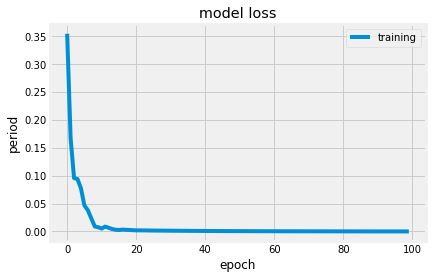

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(trainX, trainY, batch_size=256, epochs=100)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

**Obs:** 25 Epochs will do for good convergence.

In [13]:
predictions = model.predict(testX)

predict_ext = np.zeros((len(predictions), 6))
predict_ext[:,predicted_feature] = predictions[:,0]
predictions = scaler.inverse_transform(predict_ext)[:,predicted_feature]

In [14]:
testY_extended = np.zeros((len(testY),6))
testY_extended[:,predicted_feature]=testY
testY=scaler.inverse_transform(testY_extended)[:,predicted_feature]

In [15]:
# RMSE
rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
rmse

1070.6026971818271

In [16]:
# Plot the data
train = df[:train_size]
test = df[train_size:]
test

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [17]:
dataa = {'testY': testY, 'predictions': predictions}
dff = pd.DataFrame.from_dict(dataa)
dff

,testY,predictions
0,-38640.279625,-37771.993293
1,-37222.004154,-36169.523748
2,-30699.416577,-29627.462763
3,-19981.800403,-19046.575637
4,-6568.003292,-5836.069973
...,...,...
195,38132.961517,37871.768024
196,31399.515894,30720.933330
197,20906.077447,19946.106818
198,7871.245318,6951.189439


Plot:

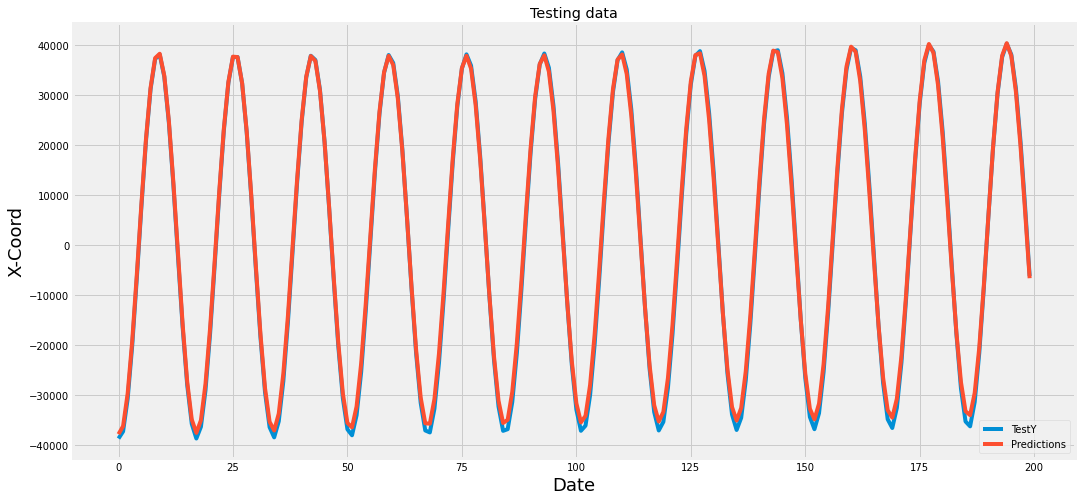

In [18]:
plt.figure(figsize=(16,8))
plt.title('Testing data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(dff.testY)
plt.plot(dff.predictions)
plt.legend(['TestY', 'Predictions'], loc='lower right')
plt.show()

Absolute Error plot:

<AxesSubplot:>

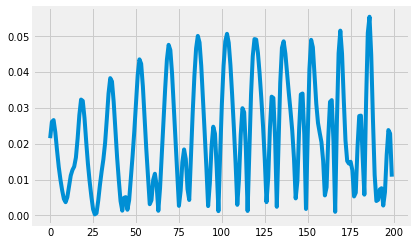

In [21]:
dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as ISS semi-major axis
dff.Error.plot()

Relative Error plot:

<AxesSubplot:>

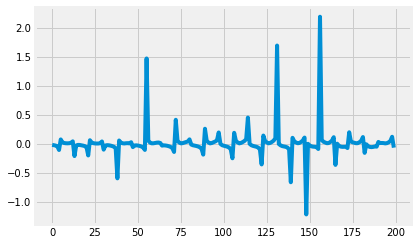

In [24]:
dff['Error']=abs(dff.predictions-dff.testY)/dff.testY # the normalization ct is taken as ISS semi-major axis
dff.Error.plot()
# for 3D case take NORM of these!!!

## This is how we predict one of the coordinates based on the 6 features.